In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sns.set_palette('PiYG')

In [92]:
df = pd.read_excel("students_internet_performance.xlsx")
df.head() #проеверка на адекватность

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,health,failures_PORTUGESE,paid_PORTUGESE,absences_PORTUGESE,finalGrade_PORTUGESE,failures_MATH,paid_MATH,absences_MATH,finalGrade_MATH
0,0,0,18,0,0,1,4,4,at_home,teacher,...,4,3,0,0,4,11,0,0,6,6
1,0,0,17,0,0,0,1,1,at_home,other,...,3,3,0,0,2,11,0,0,4,6
2,0,0,15,0,1,0,1,1,at_home,other,...,2,3,0,0,6,12,3,1,10,10
3,0,0,15,0,0,0,4,2,health,services,...,2,5,0,0,0,14,0,1,2,15
4,0,0,16,0,0,0,3,3,other,other,...,2,5,0,0,0,13,0,1,4,10


In [93]:
df.shape

(370, 31)

In [94]:
#df.info()

In [95]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'studytime', 'schoolsup', 'famsup',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'failures_PORTUGESE', 'paid_PORTUGESE',
       'absences_PORTUGESE', 'finalGrade_PORTUGESE', 'failures_MATH',
       'paid_MATH', 'absences_MATH', 'finalGrade_MATH'],
      dtype='object')

In [96]:
df = pd.get_dummies(df, columns = ['Mjob', 'Fjob', 'reason']).astype('int64')
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'studytime', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health',
       'failures_PORTUGESE', 'paid_PORTUGESE', 'absences_PORTUGESE',
       'finalGrade_PORTUGESE', 'failures_MATH', 'paid_MATH', 'absences_MATH',
       'finalGrade_MATH', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation'],
      dtype='object')

In [97]:
#df.info()

In [98]:
df_continuous = df[['age','absences_PORTUGESE','absences_MATH','finalGrade_PORTUGESE','finalGrade_MATH']]
df_ordinal = df[['Medu', 'Fedu', 'studytime', 'famrel', 'freetime', 'goout', 'health', 'failures_PORTUGESE', 'failures_MATH']]
df_dummy = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
               'internet', 'romantic', 'paid_PORTUGESE', 'paid_MATH', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
               'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
               'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
               'reason_home', 'reason_other', 'reason_reputation']]

# Первичный анализ

In [99]:
df_continuous.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,370.0,16.58,1.18,15.0,16.0,17.0,17.0,22.0
absences_PORTUGESE,370.0,3.63,4.83,0.0,0.0,2.0,6.0,32.0
absences_MATH,370.0,5.38,7.67,0.0,0.0,4.0,8.0,75.0
finalGrade_PORTUGESE,370.0,12.55,2.94,0.0,11.0,13.0,14.0,19.0
finalGrade_MATH,370.0,10.46,4.61,0.0,8.0,11.0,14.0,20.0


In [100]:
df_ordinal.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Medu,370.0,2.80,1.08,0.0,2.0,3.0,4.00,4.0
Fedu,370.0,2.56,1.09,0.0,2.0,3.0,3.75,4.0
studytime,370.0,2.04,0.85,1.0,1.0,2.0,2.00,4.0
famrel,370.0,3.94,0.91,1.0,4.0,4.0,5.00,5.0
freetime,370.0,3.22,0.99,1.0,3.0,3.0,4.00,5.0
goout,370.0,3.12,1.13,1.0,2.0,3.0,4.00,5.0
health,370.0,3.56,1.41,1.0,3.0,4.0,5.00,5.0
failures_PORTUGESE,370.0,0.13,0.49,0.0,0.0,0.0,0.00,3.0
failures_MATH,370.0,0.28,0.71,0.0,0.0,0.0,0.00,3.0


In [101]:
df.nunique()

school                   2
sex                      2
age                      7
address                  2
famsize                  2
Pstatus                  2
Medu                     5
Fedu                     5
studytime                4
schoolsup                2
famsup                   2
activities               2
nursery                  2
higher                   2
internet                 2
romantic                 2
famrel                   5
freetime                 5
goout                    5
health                   5
failures_PORTUGESE       4
paid_PORTUGESE           2
absences_PORTUGESE      19
finalGrade_PORTUGESE    17
failures_MATH            4
paid_MATH                2
absences_MATH           32
finalGrade_MATH         18
Mjob_at_home             2
Mjob_health              2
Mjob_other               2
Mjob_services            2
Mjob_teacher             2
Fjob_at_home             2
Fjob_health              2
Fjob_other               2
Fjob_services            2
F

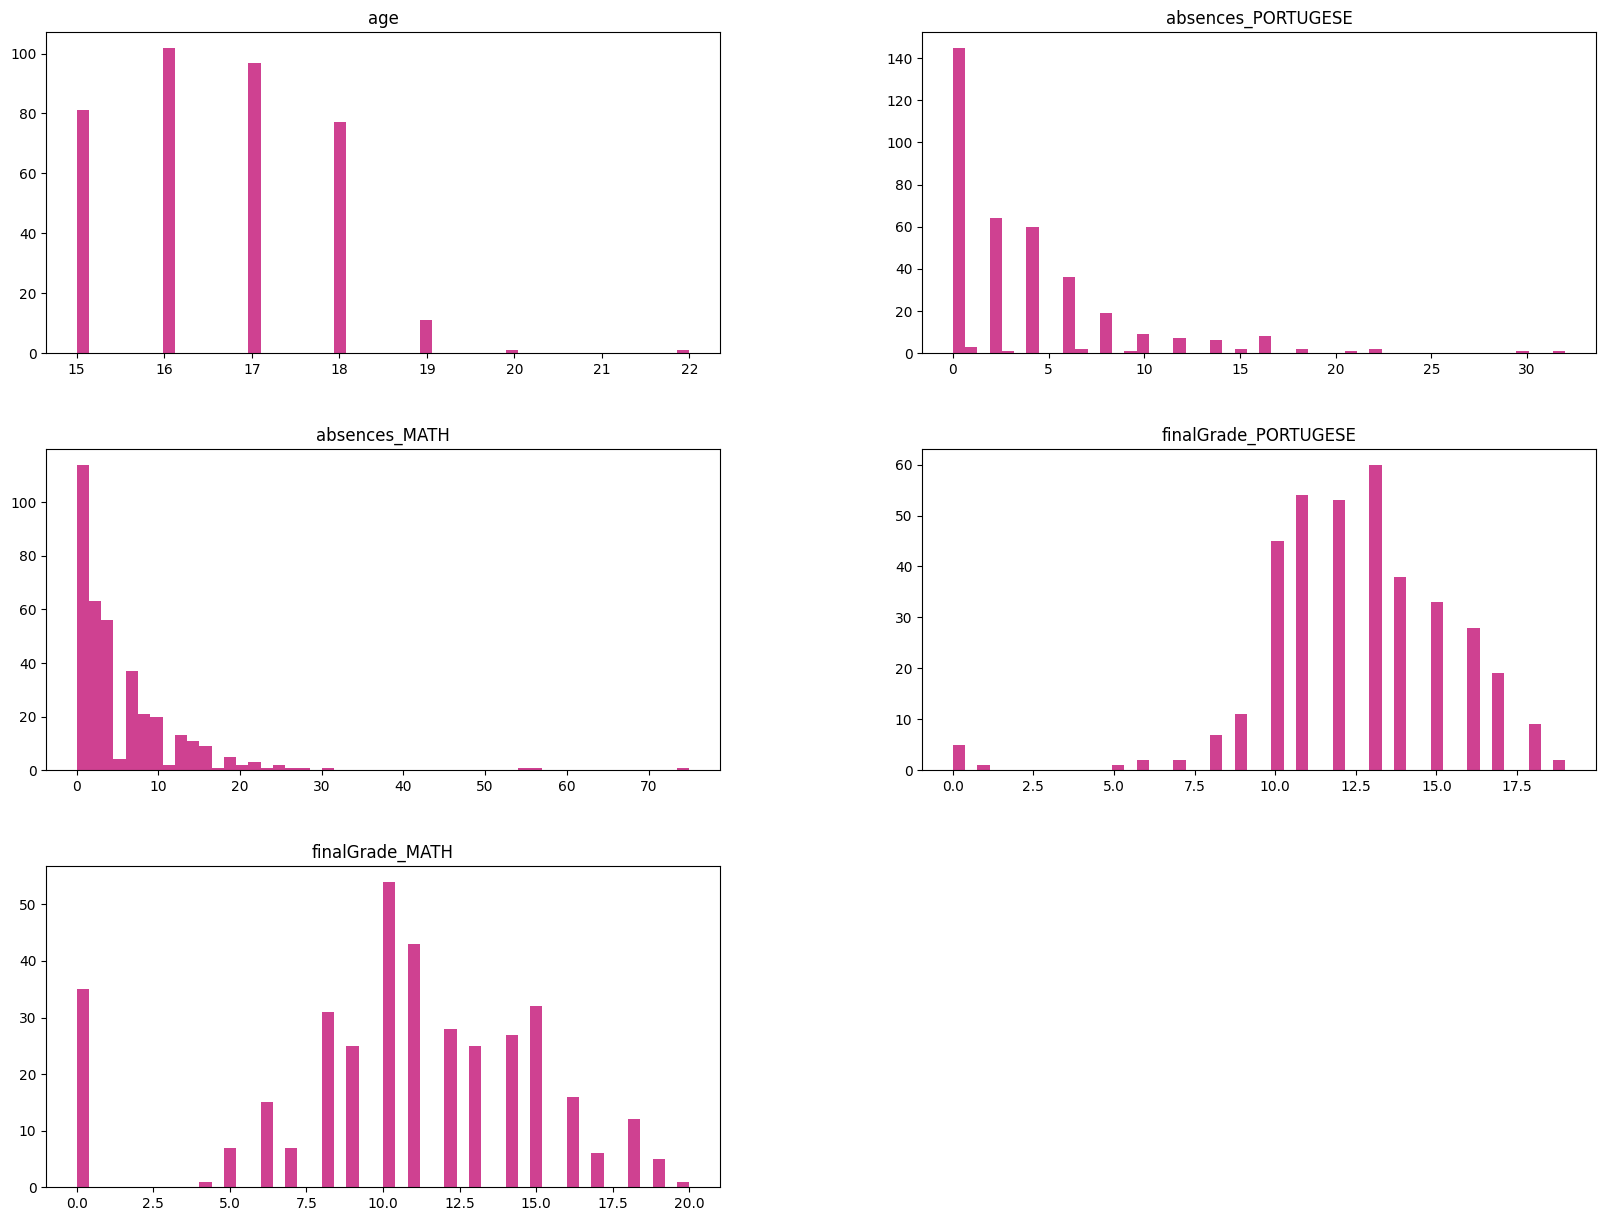

In [102]:
df_continuous.hist(grid=False, bins=50, figsize=(20,15))
plt.show()

Распределения далеки от нормальных, будут особенности в методах

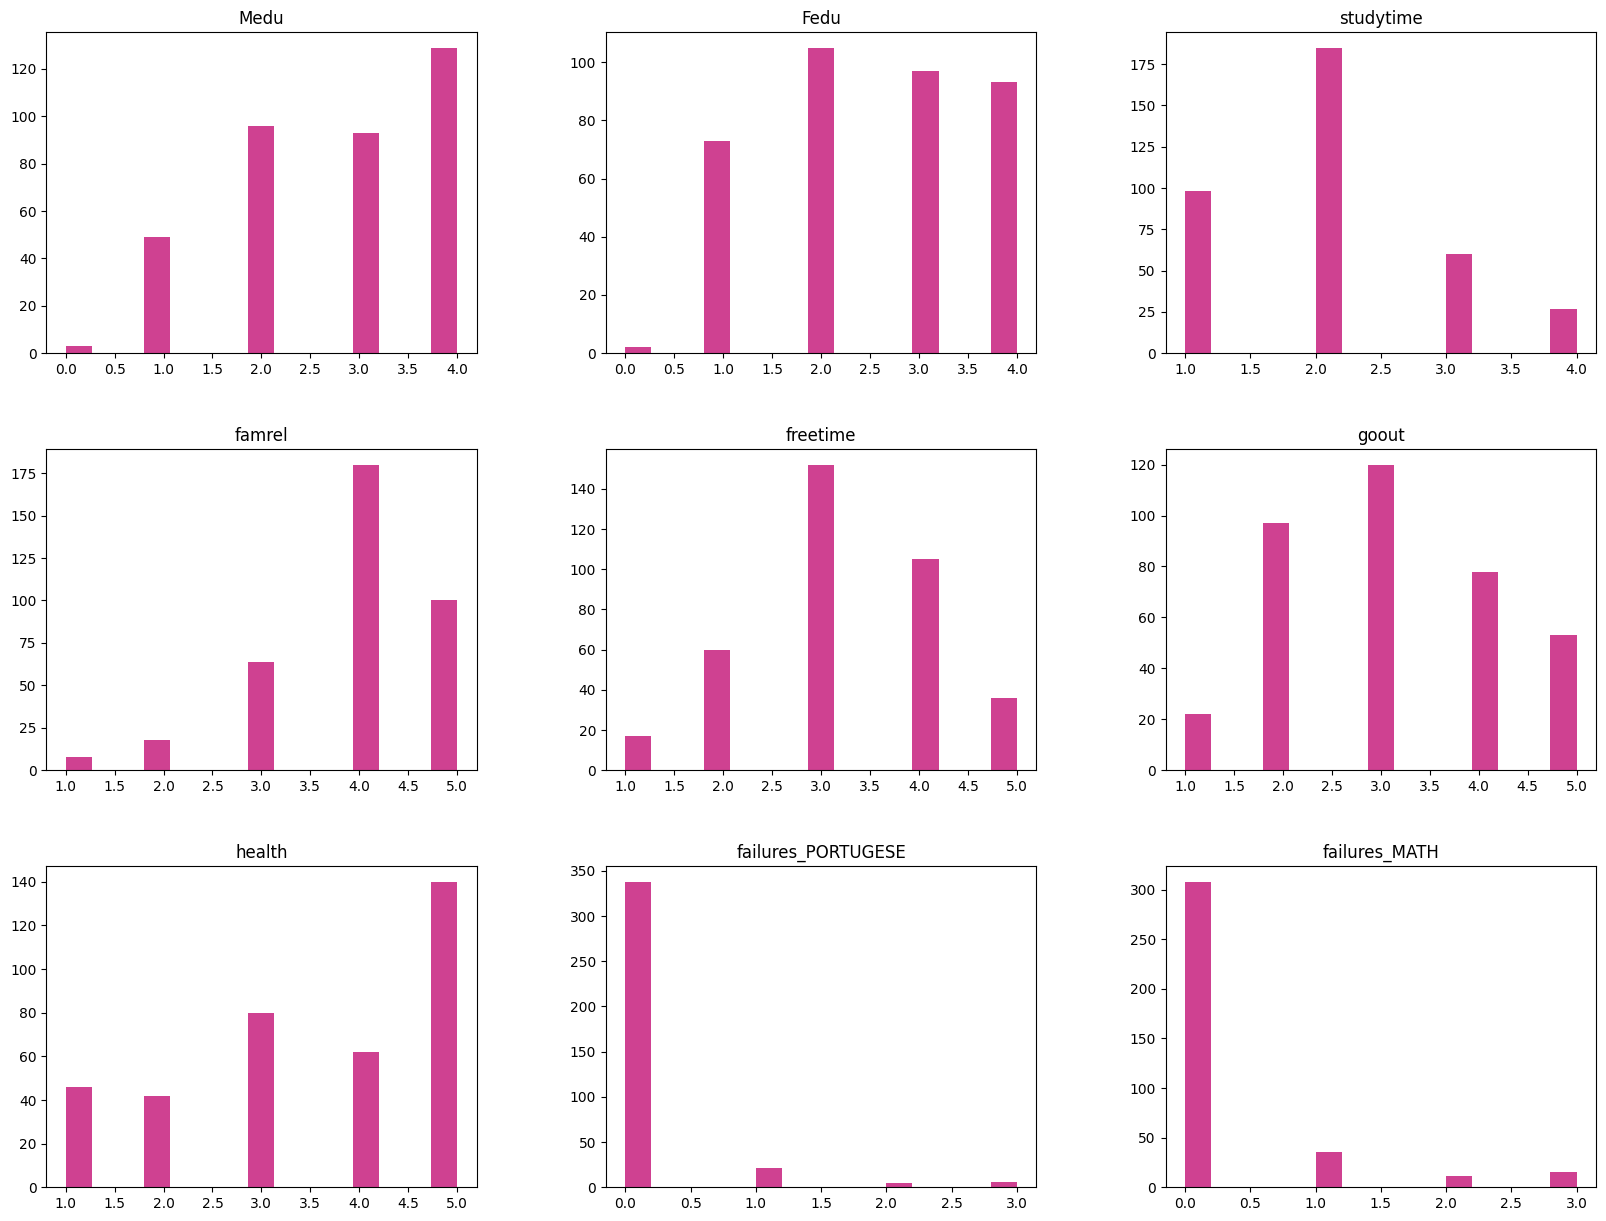

In [103]:
df_ordinal.hist(grid=False, bins=15, figsize=(20,15))
plt.show()

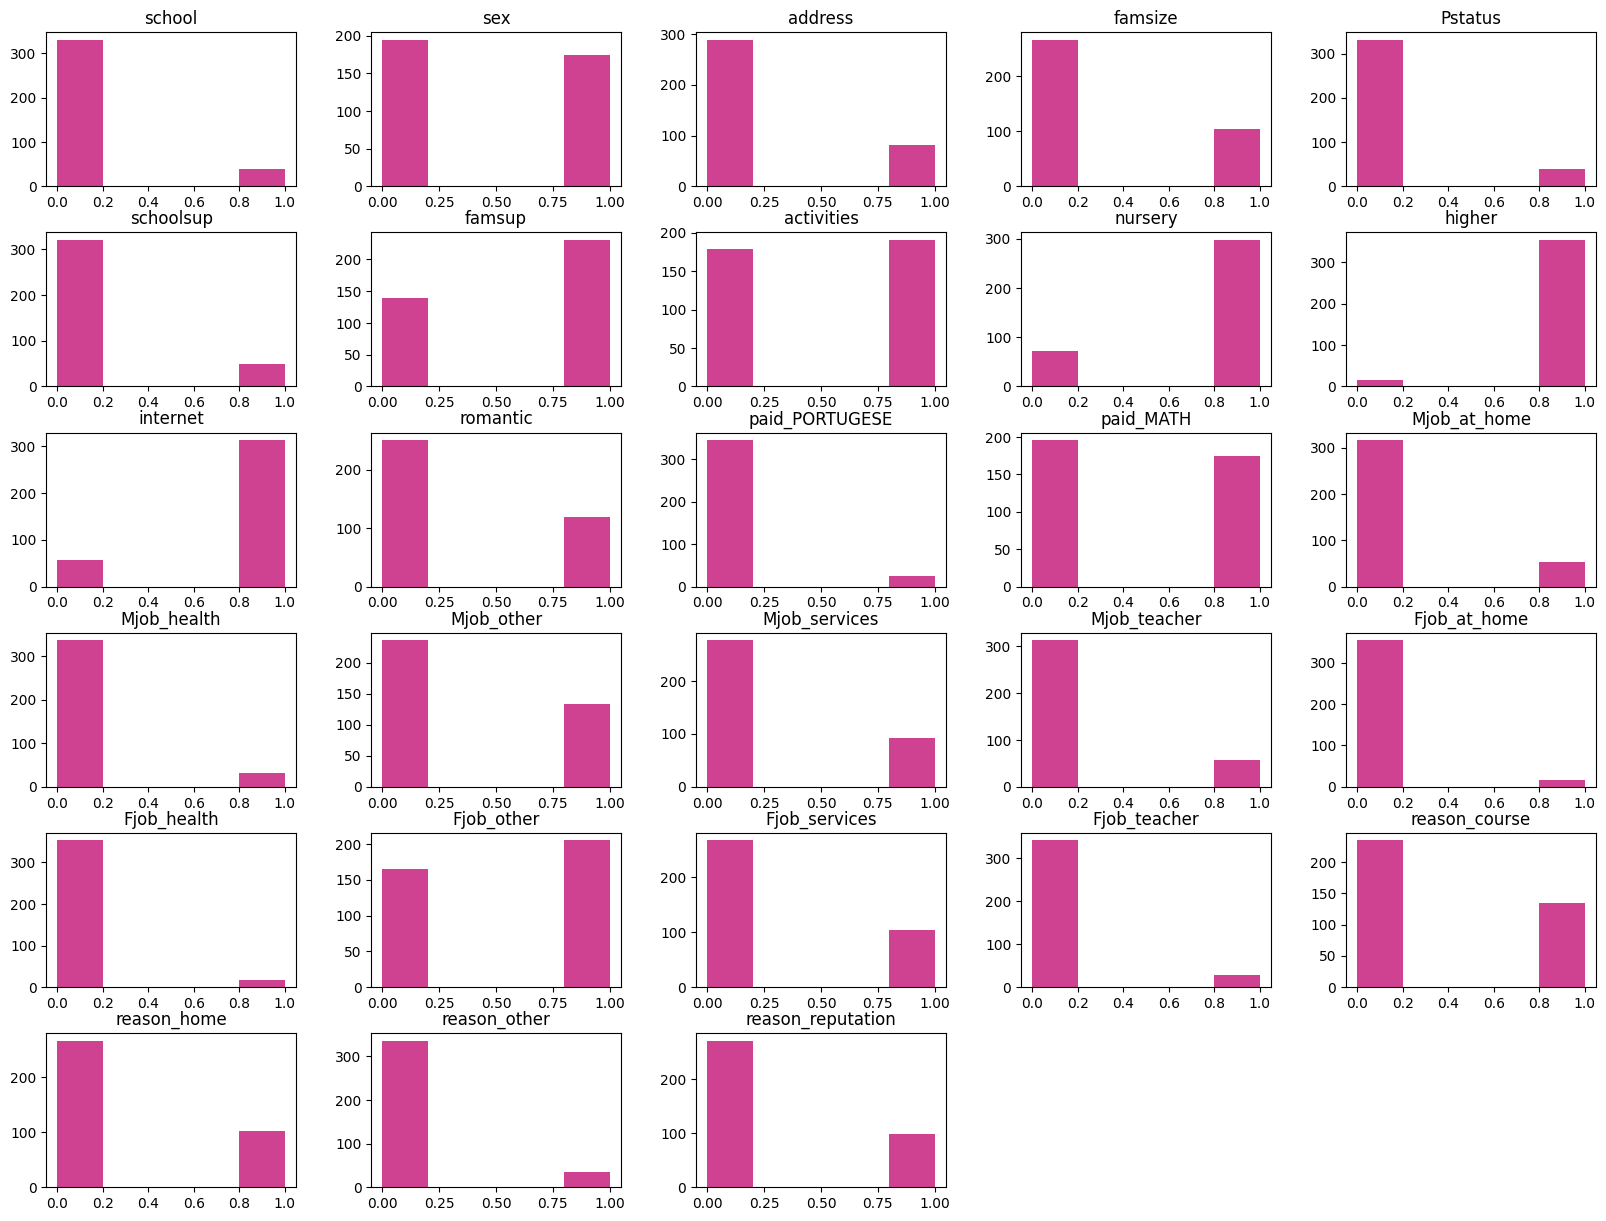

In [104]:
df_dummy.hist(grid=False, bins=5, figsize=(20,15))
plt.show()

Эти гистограммы созданы для понимания долей, не более

# Выбросы

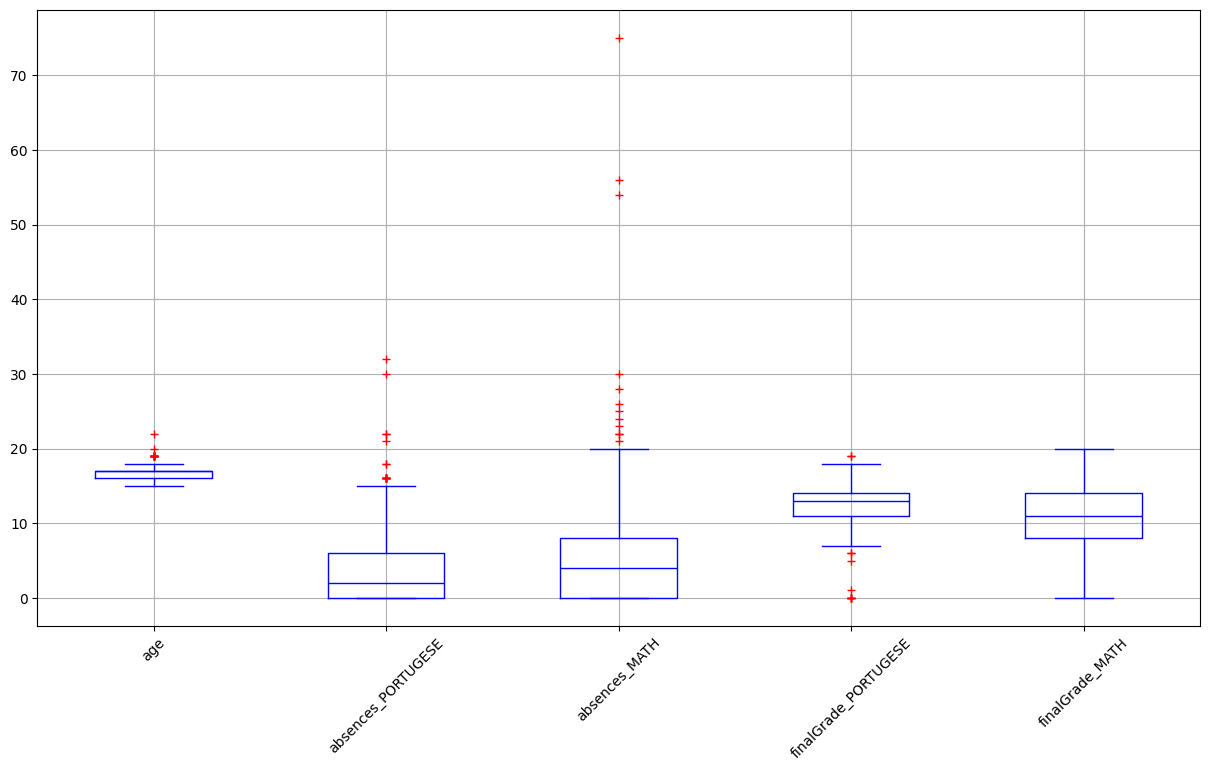

In [105]:
plt.figure(figsize=(15,8))
df_continuous.boxplot(color='b',sym='r+')
plt.xticks(rotation=45)
plt.show()

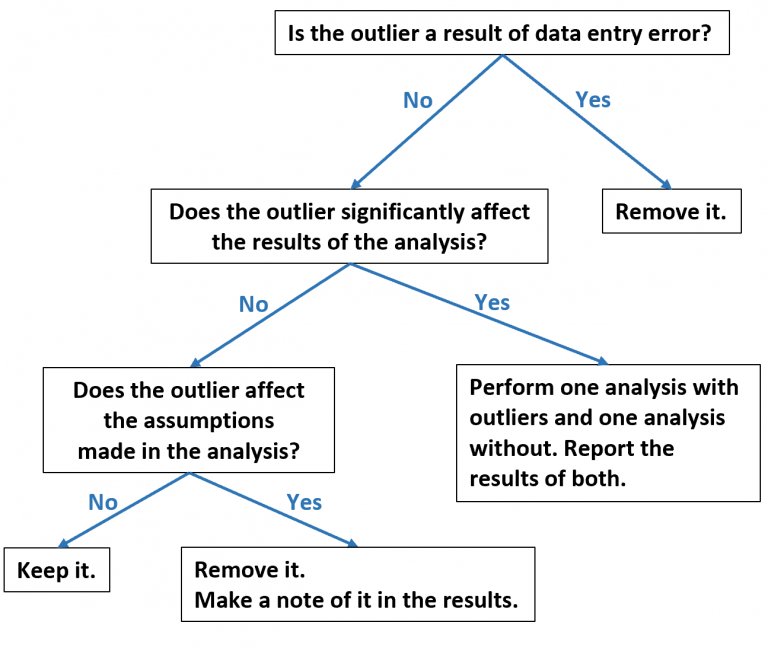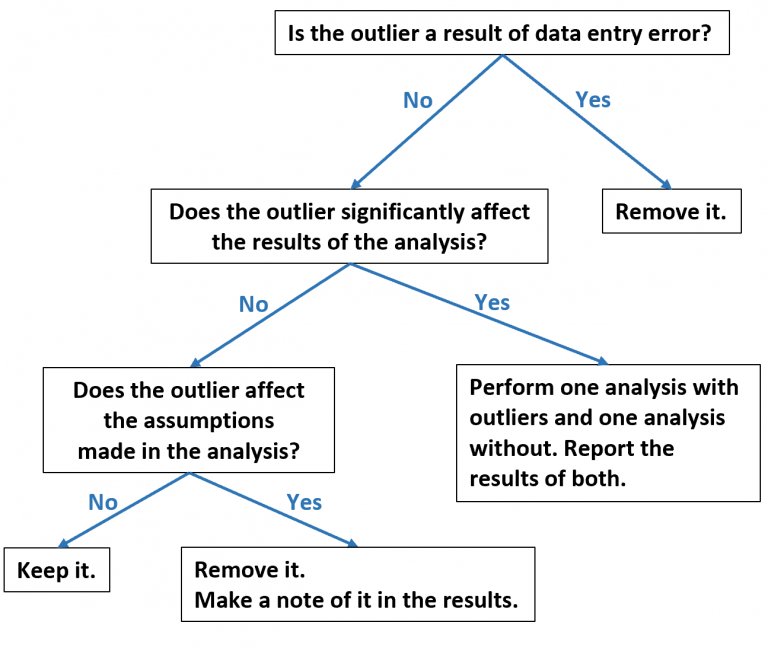

Может быть исключу выбросы в прогулах, оценки и возраст трогать не буду.

# Корреляция (проверка на мультиколлениарность)

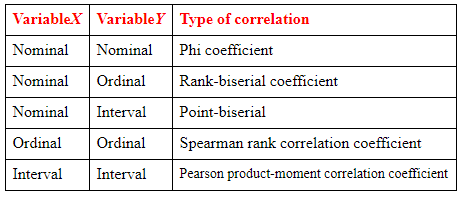

<Axes: >

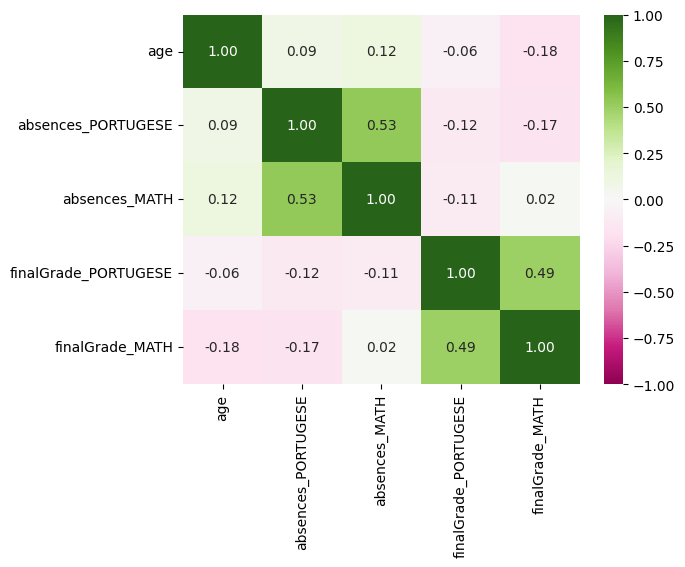

In [106]:
sns.heatmap(df_continuous.corr(method='pearson'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

https://statstutor.ac.uk/resources/uploaded/spearmans.pdf

<Axes: >

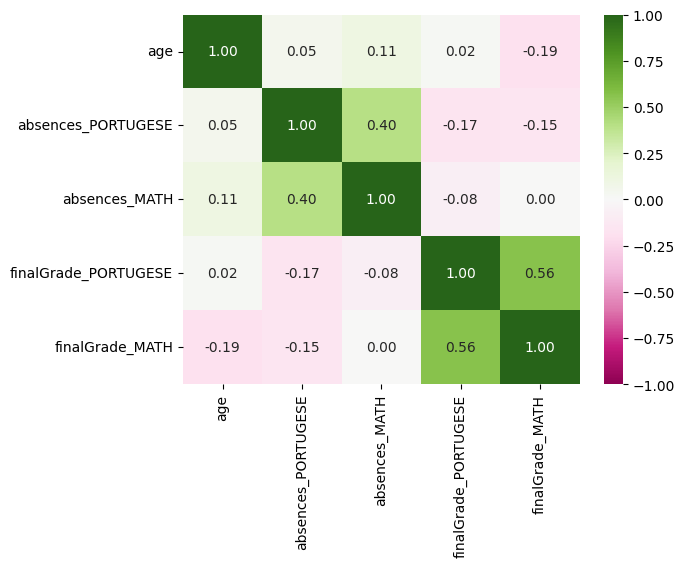

In [107]:
sns.heatmap(df_continuous.corr(method='spearman'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

<Axes: >

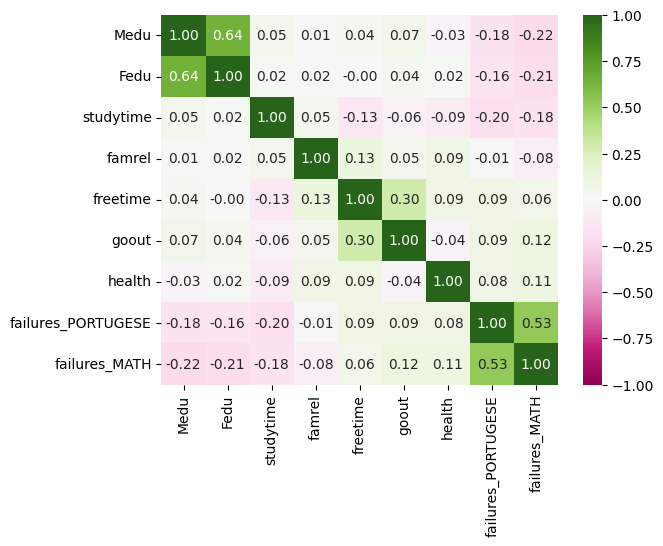

In [108]:
sns.heatmap(df_ordinal.corr(method='spearman'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

<Axes: >

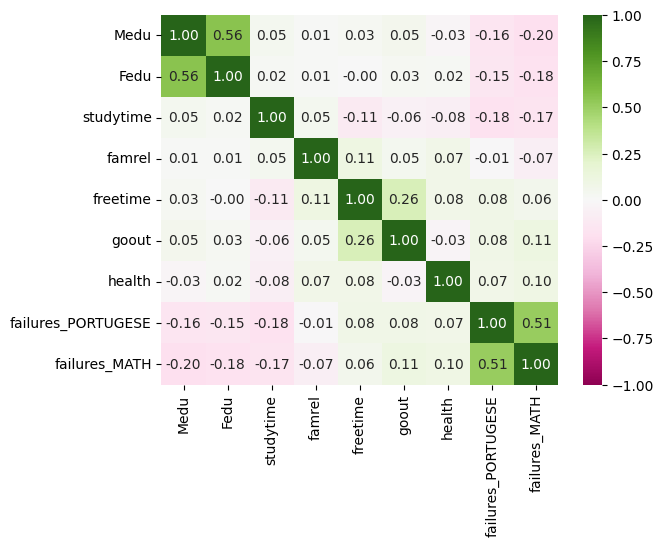

In [109]:
sns.heatmap(df_ordinal.corr(method='kendall'), cmap="PiYG", annot=True, fmt='.2f', vmin=-1, vmax=1)

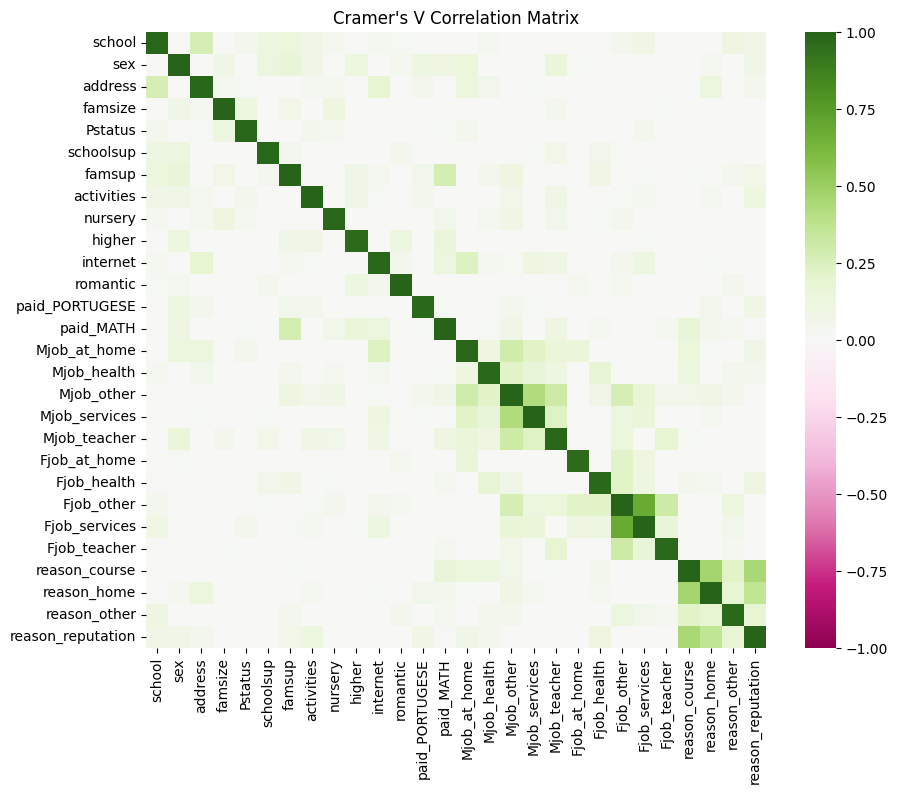

In [110]:
def cramers_v(x, y):
    """Calculate Cramer's V statistic for categorial-categorial association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def create_cramers_v_matrix(data):
    """Create a Cramer's V matrix for a DataFrame of categorical variables."""
    cols = data.columns
    corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    for col1 in cols:
        for col2 in cols:
            corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])
    return corr_matrix

data = df_dummy

# Calculate Cramer's V matrix
cramers_v_matrix = create_cramers_v_matrix(data)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=False, fmt=".2f", vmin=-1, vmax=1, cmap='PiYG')
plt.title('Cramer\'s V Correlation Matrix')
plt.show()

Можно еще посчитать VIF (коэффициент инфляции дисперсии), граничное значение 5 или 10.

# Коэффициент инфляции дисперсии

In [111]:
# vif для всех заданных переменных
def compute_vif(considered_features):
    
    X = df[considered_features]
    # дабавляем константу
    X['intercept'] = 1
    
    # создаем таблицу для vif
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

considered_features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                       'studytime', 'schoolsup', 'famsup',
                       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
                       'freetime', 'goout', 'health', 'failures_PORTUGESE', 'paid_PORTUGESE', 'absences_PORTUGESE']

compute_vif(considered_features).sort_values('VIF', ascending=False).head()

#                   'Mjob_at_home', 'Mjob_health', 'Mjob_other',
#                   'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
#                   'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
#                   'reason_home', 'reason_other', 'reason_reputation'

/var/folders/88/m003r1ks0ks7zyd1v94qccym0000gn/T/ipykernel_87634/3600430489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
6,Medu,1.872231
7,Fedu,1.771503
2,age,1.476908
0,school,1.353953
1,sex,1.323156


In [112]:
considered_features = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
                       'studytime', 'schoolsup', 'famsup',
                       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
                       'freetime', 'goout', 'health', 'failures_MATH', 'paid_MATH', 'absences_MATH']

compute_vif(considered_features).sort_values('VIF', ascending=False).head()

/var/folders/88/m003r1ks0ks7zyd1v94qccym0000gn/T/ipykernel_87634/3600430489.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
6,Medu,1.902906
7,Fedu,1.787701
2,age,1.428659
0,school,1.352508
13,higher,1.317144


Итог: мультиколлинеарности не наблюдается

# Определение связи независимых переменных с зависимой

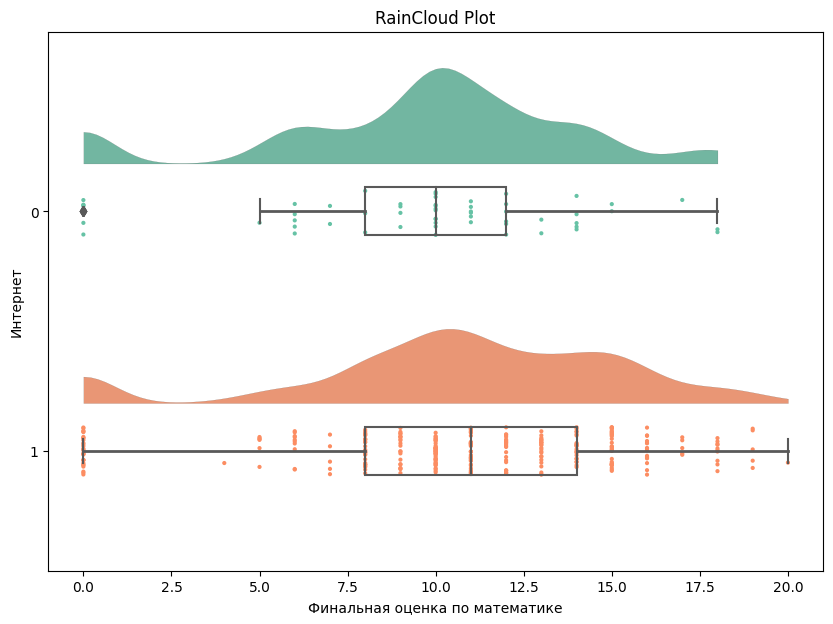

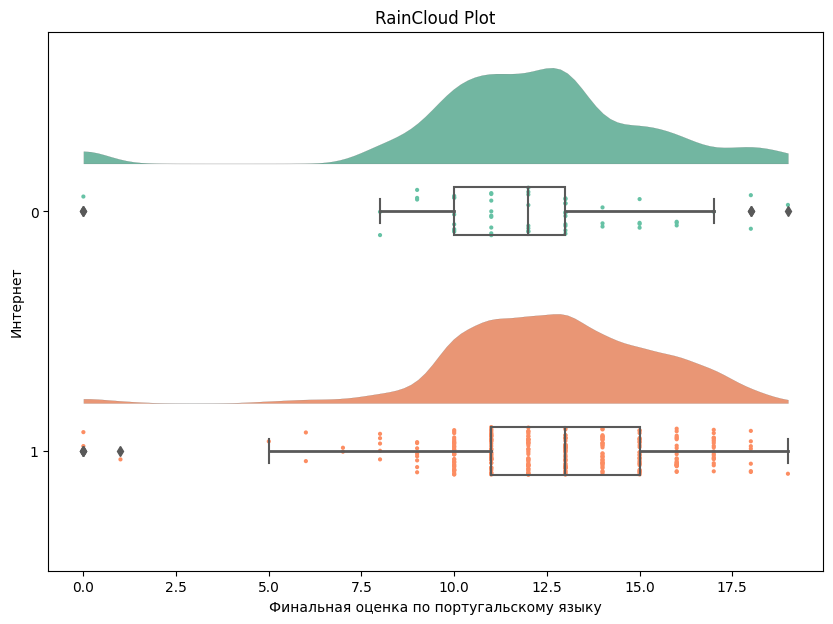

/var/folders/88/m003r1ks0ks7zyd1v94qccym0000gn/T/ipykernel_87634/2485432170.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='internet', y='finalGrade_PORTUGESE', inner='stick', palette='PiYG')


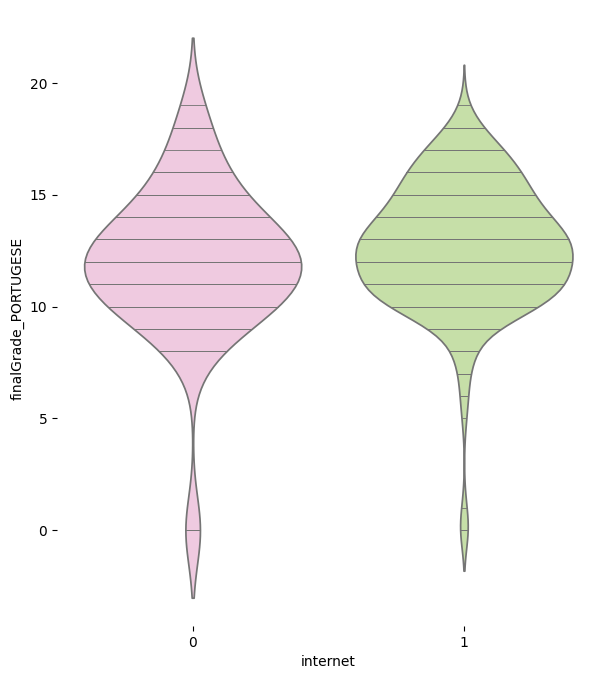

In [113]:
figsize = (7, 4 * len(df['internet'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='internet', y='finalGrade_PORTUGESE', inner='stick', palette='PiYG')
sns.despine(top=True, right=True, bottom=True, left=True)

/var/folders/88/m003r1ks0ks7zyd1v94qccym0000gn/T/ipykernel_87634/3706998620.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='internet', y='finalGrade_MATH', inner='stick', palette='PiYG')


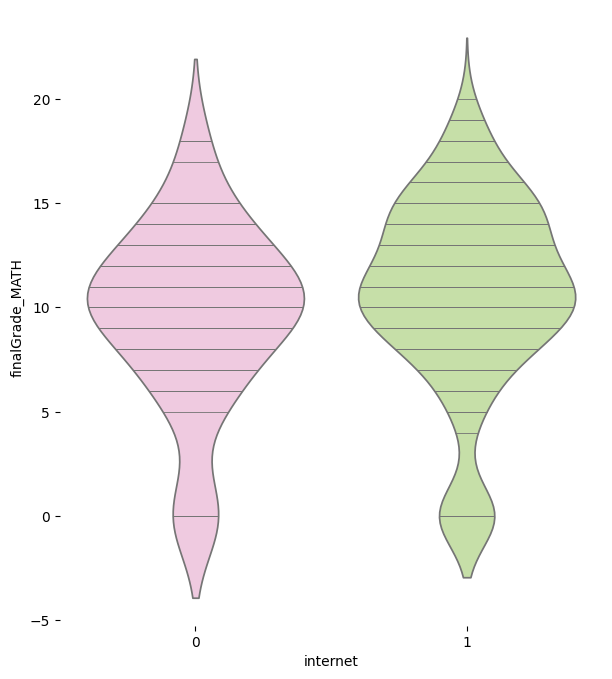

In [114]:
figsize = (7, 4 * len(df['internet'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='internet', y='finalGrade_MATH', inner='stick', palette='PiYG')
sns.despine(top=True, right=True, bottom=True, left=True)

In [115]:
corr_matrix = df.corr()
corr_matrix["finalGrade_PORTUGESE"].sort_values(ascending=False)

finalGrade_PORTUGESE    1.000000
finalGrade_MATH         0.493134
higher                  0.306750
studytime               0.272667
Medu                    0.201374
Fedu                    0.165172
reason_reputation       0.124393
Mjob_teacher            0.123312
Mjob_health             0.115211
activities              0.114387
famsup                  0.094946
paid_MATH               0.089513
internet                0.082977
Fjob_at_home            0.081971
Fjob_teacher            0.081868
Pstatus                 0.075551
nursery                 0.074064
famrel                  0.038690
famsize                 0.035543
reason_home             0.030631
Fjob_health             0.024508
Mjob_services           0.011600
Mjob_at_home           -0.032451
Fjob_services          -0.039113
romantic               -0.039233
Fjob_other             -0.052864
age                    -0.062391
reason_course          -0.066458
absences_MATH          -0.105461
freetime               -0.106483
absences_P

# ANOVA

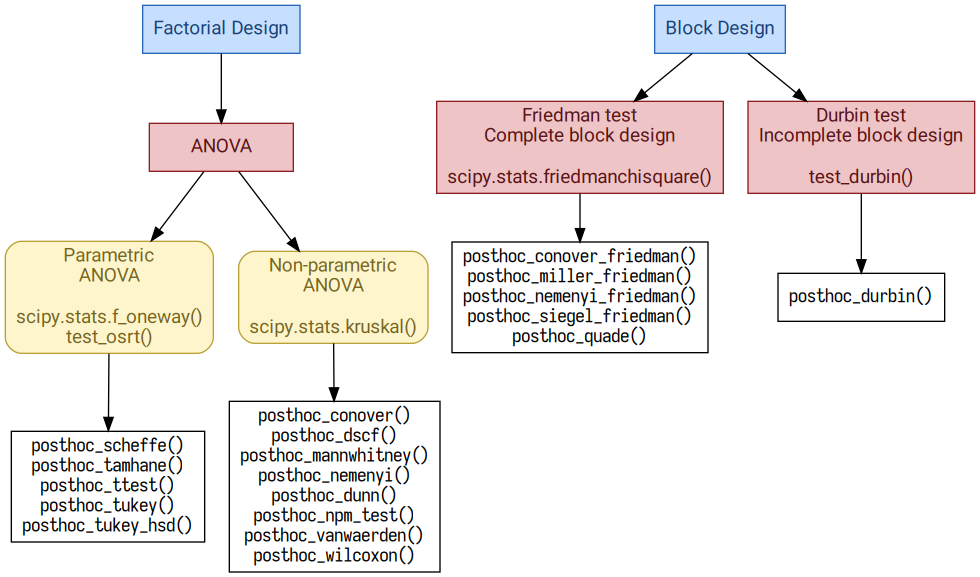

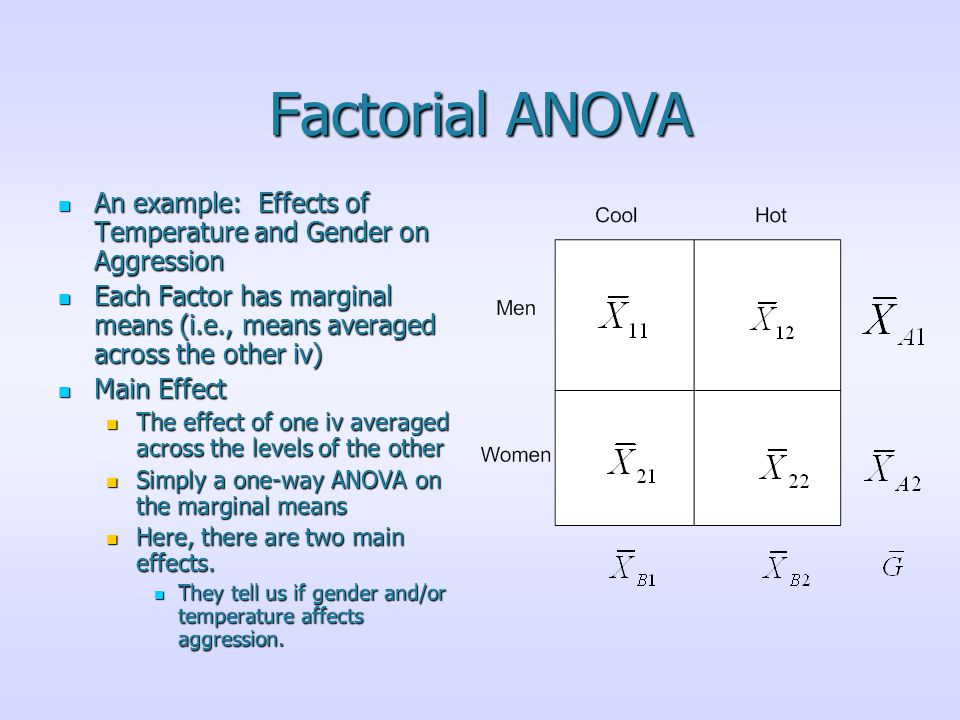

In [116]:
from scipy.stats import f_oneway
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [117]:
## Португальский

In [118]:
f_oneway(df['finalGrade_PORTUGESE'],df['internet'])

F_onewayResult(statistic=5766.356386867693, pvalue=0.0)

Какое-то слишком большое значение у F-statistics. Вероятно из-за выбросов. Но они не то чтобы ярко выражены, хз.

In [119]:
lm = sfa.ols('finalGrade_PORTUGESE ~ C(internet)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

                df       sum_sq    mean_sq         F    PR(>F)
C(internet)    1.0    22.014738  22.014738  2.551305  0.111062
Residual     368.0  3175.404181   8.628816       NaN       NaN


In [120]:
f_oneway(df['finalGrade_PORTUGESE'],df['address'])

F_onewayResult(statistic=6370.989216331495, pvalue=0.0)

In [121]:
lm = sfa.ols('finalGrade_PORTUGESE ~ C(address)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

               df       sum_sq     mean_sq          F    PR(>F)
C(address)    1.0   127.681895  127.681895  15.306502  0.000109
Residual    368.0  3069.737024    8.341677        NaN       NaN


In [122]:
## Математика

In [123]:
f_oneway(df['finalGrade_MATH'],df['internet'])

F_onewayResult(statistic=1601.8041256828064, pvalue=4.318579854391577e-187)

In [124]:
lm = sfa.ols('finalGrade_MATH ~ C(internet)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

                df       sum_sq    mean_sq         F    PR(>F)
C(internet)    1.0    52.883331  52.883331  2.499764  0.114722
Residual     368.0  7785.159913  21.155326       NaN       NaN


In [125]:
f_oneway(df['finalGrade_MATH'],df['address'])

F_onewayResult(statistic=1813.98238369617, pvalue=5.2069705400382706e-201)

In [126]:
lm = sfa.ols('finalGrade_MATH ~ C(address)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

               df       sum_sq    mean_sq         F    PR(>F)
C(address)    1.0    85.745665  85.745665  4.070329  0.044368
Residual    368.0  7752.297578  21.066026       NaN       NaN


Можно говорить об отвержении нулевой гипотезы (H0: равенство средних значений) для адреса. С интернетом сложнее.

Можно еще и two-way анову прогнать для двух факторов.

In [127]:
#perform two-way ANOVA
model = ols('finalGrade_PORTUGESE ~ C(internet) + C(address) + C(internet):C(address)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(internet),5.699687,1.0,0.681051,0.409763
C(address),111.366844,1.0,13.307136,0.000303
C(internet):C(address),0.999228,1.0,0.119397,0.729888
Residual,3063.038109,366.0,NaN,NaN


Интернет как будто бы не значим

In [128]:
#perform two-way ANOVA
model = ols('finalGrade_MATH ~ C(internet) + C(address) + C(internet):C(address)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(internet),29.818218,1.0,1.413678,0.235218
C(address),62.680553,1.0,2.971678,0.085578
C(internet):C(address),2.571434,1.0,0.121911,0.727171
Residual,7719.907926,366.0,NaN,NaN


Здесь ничего не значимо :)

# Выбор модели

Выбор по-тупому:
* Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [130]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [131]:
df.shape

(370, 42)

## Что-то типо оверфита, модель носит вспомогательный характер

In [132]:
import statsmodels.api as sm

X = df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'studytime', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health',
       'failures_PORTUGESE', 'paid_PORTUGESE', 'absences_PORTUGESE',
       'failures_MATH', 'paid_MATH', 'absences_MATH',
       'finalGrade_MATH', 'Mjob_at_home', 'Mjob_health', 'Mjob_other',
       'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health',
       'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course',
       'reason_home', 'reason_other', 'reason_reputation']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.625
Model:                              OLS   Adj. R-squared:                  0.565
Method:                   Least Squares   F-statistic:                     480.9
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):          1.40e-204
Time:                          16:48:29   Log-Likelihood:                -560.20
No. Observations:                   277   AIC:                             1198.
Df Residuals:                       238   BIC:                             1340.
Df Model:                            38                                         
Covariance Type:                    HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 41, but rank is 39
  warnings.warn('covariance of constraints does not have full '


## Выбор переменных исходя из предполагаемой значимости

In [133]:
X = df[['absences_PORTUGESE','failures_PORTUGESE','finalGrade_MATH','Fjob_teacher','higher','studytime','schoolsup','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.501
Model:                              OLS   Adj. R-squared:                  0.484
Method:                   Least Squares   F-statistic:                     28.84
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):           9.21e-35
Time:                          16:48:31   Log-Likelihood:                -599.79
No. Observations:                   277   AIC:                             1220.
Df Residuals:                       267   BIC:                             1256.
Df Model:                             9                                         
Covariance Type:                    HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

In [134]:
X = df[['absences_MATH','failures_MATH','finalGrade_PORTUGESE','Fjob_teacher','higher','studytime','schoolsup','sex','internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        finalGrade_MATH   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     16.38
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           2.26e-21
Time:                        16:48:35   Log-Likelihood:                -758.11
No. Observations:                 277   AIC:                             1536.
Df Residuals:                     267   BIC:                             1572.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.8956 

## От одного ко многим: Математика

In [135]:
X = df[['internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        finalGrade_MATH   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.993
Date:                Wed, 24 Apr 2024   Prob (F-statistic):             0.0467
Time:                        16:48:39   Log-Likelihood:                -817.33
No. Observations:                 277   AIC:                             1639.
Df Residuals:                     275   BIC:                             1646.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9048      0.717     12.424      0.0

Может быть из-за
* Confounding variabe: https://www.statology.org/confounding-variable/
* Поэтому боремся с omitted variable bias

In [136]:
X = df[['absences_MATH','internet']]
y =df[['finalGrade_MATH']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        finalGrade_MATH   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.990
Date:                Wed, 24 Apr 2024   Prob (F-statistic):              0.139
Time:                        16:48:40   Log-Likelihood:                -817.32
No. Observations:                 277   AIC:                             1641.
Df Residuals:                     274   BIC:                             1652.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.9238      0.733     12.177

*подбирала всякое разное, не очень успешно*

## От одного ко многим: Португальский

In [137]:
X = df[['internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.010
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     1.912
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):              0.168
Time:                          16:48:42   Log-Likelihood:                -694.76
No. Observations:                   277   AIC:                             1394.
Df Residuals:                       275   BIC:                             1401.
Df Model:                             1                                         
Covariance Type:                    HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7619      0.567

In [138]:
X = df[['sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.078
Model:                              OLS   Adj. R-squared:                  0.071
Method:                   Least Squares   F-statistic:                     9.726
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):           8.30e-05
Time:                          16:48:44   Log-Likelihood:                -684.86
No. Observations:                   277   AIC:                             1376.
Df Residuals:                       274   BIC:                             1387.
Df Model:                             2                                         
Covariance Type:                    HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3594      0.511

In [139]:
X = df[['studytime','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.134
Model:                              OLS   Adj. R-squared:                  0.125
Method:                   Least Squares   F-statistic:                     9.890
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):           3.27e-06
Time:                          16:48:46   Log-Likelihood:                -676.15
No. Observations:                   277   AIC:                             1360.
Df Residuals:                       273   BIC:                             1375.
Df Model:                             3                                         
Covariance Type:                    HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.3692      0.675

In [140]:
X = df[['finalGrade_MATH','studytime','sex','internet']]
y =df[['finalGrade_PORTUGESE']]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model using statsmodels
model = sm.OLS(y_train, X_train).fit(cov_type='HC1')

# Display the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     finalGrade_PORTUGESE   R-squared:                       0.392
Model:                              OLS   Adj. R-squared:                  0.383
Method:                   Least Squares   F-statistic:                     29.10
Date:                  Wed, 24 Apr 2024   Prob (F-statistic):           3.81e-20
Time:                          16:48:48   Log-Likelihood:                -627.32
No. Observations:                   277   AIC:                             1265.
Df Residuals:                       272   BIC:                             1283.
Df Model:                             4                                         
Covariance Type:                    HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.

In [ ]:
# Можно попробовать без кроссвалидации
# Либо сказать, что переменная не значима и объяснить почему

In [ ]:
# Тут тесты на нормальность остатков, Уайт, Бреуш-Пааган